# LABORATORIO #1 

*   Nombre: **Colque Garcia Ariel Rodrigo**
*   CU: **111-36**

*DATASET:* **Diabetic Retinopathy 224x224 (2019 Data)**


El dataset *Diabetic Retinopathy 224x224 (2019 Data)* es un conjunto de imágenes de escaneos de retina para detectar la retinopatía diabética. La retinopatía diabética es una complicación de la diabetes que afecta a la visión. El dataset original está disponible en APTOS 2019 Blindness Detection1. Las imágenes están redimensionadas a 224x224 píxeles para que puedan ser usadas fácilmente con muchos modelos de aprendizaje profundo pre-entrenados.

El dataset contiene 3662 imágenes en total, divididas en 5 clases según la severidad o el estadio de la retinopatía diabética:

* Clase 0: Sin DR
* Clase 1: DR leve
* Clase 2: DR moderada
* Clase 3: DR severa
* Clase 4: PDR (proliferative diabetic retinopathy)

Las imágenes están guardadas en sus respectivas carpetas según la clase a la que pertenecen.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torchvision
import torch

In [99]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Obtencion de los datos

In [ ]:
# Para dividir el dataset en train y test
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
# Dividimos el dataset en train y test con un 70%(train) y 30%(test)
splitfolders.ratio('/content/drive/MyDrive/Data/colored_images', output='/content/drive/MyDrive/Data/split', seed=42, ratio=(0.7, 0.3))

Copying files: 3662 files [01:26, 42.50 files/s]


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # añade un volteo horizontal aleatorio
    transforms.RandomRotation(10), # añade una rotación aleatoria de 10 grados
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # añade un cambio aleatorio en el brillo y el contraste
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
diabetic_train = datasets.ImageFolder(root='/content/drive/MyDrive/Data/split/train', transform=transform)
diabetic_test = datasets.ImageFolder(root='/content/drive/MyDrive/Data/split/test', transform=transform)
# Total datos: 3660
# Datos Train: 2548 --> 70%
# Datos Test: 1100 --> 30%

#Visualizacion de las imagenes

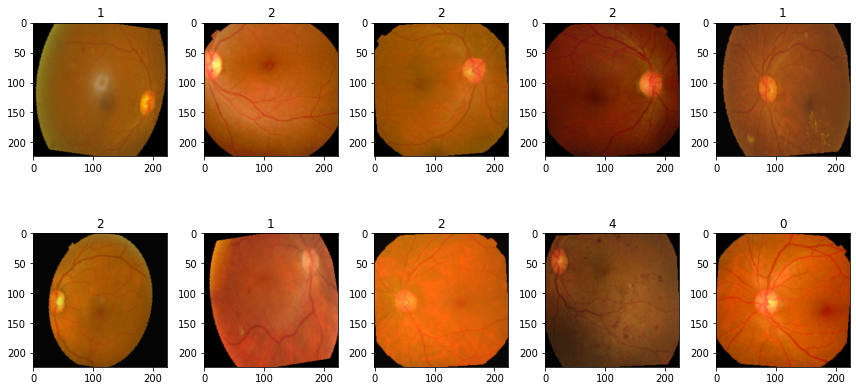

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Función para desnormalizar una imagen
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Función para mostrar una imagen
def show_image(image):
    plt.imshow(denormalize(image))

# Crear una figura con una cuadrícula de 2x5 subgráficos
plt.figure(figsize=(12,6))
for i in range(10):
    # Seleccionar una imagen aleatoria del conjunto de entrenamiento
    index = np.random.randint(len(diabetic_train))
    image, label = diabetic_train[index]

    # Mostrar la imagen y la etiqueta en el subgráfico correspondiente
    plt.subplot(2,5,i+1)
    show_image(image)
    plt.title(label)

# Ajustar el espacio entre los subgráficos
plt.tight_layout()
# Mostrar la figura completa
plt.show()

In [8]:

print(diabetic_train.classes[4])

Severe


#Arquitectura ResNet18

In [ ]:
resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Modelo

In [62]:
class Diabetic(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [58]:
model_custom = Diabetic()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

#Entrenamiento

In [63]:
dataloader = {}
dataloader['train'] = torch.utils.data.DataLoader(diabetic_train, batch_size=64, shuffle=True)
dataloader['test'] = torch.utils.data.DataLoader(diabetic_test, batch_size=64, shuffle=False)

In [64]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

In [110]:
# Ahora, este metodo recibe el PATH donde se guardara el checkpoint
def fit(model, dataloader, epochs=5,  lr=0.0001, PATH=''):
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []

  model.to(device)
  # Utilizamos el Optimizador ADAM
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.CrossEntropyLoss()

  # Cargar el checkpoint si existe
  if os.path.exists(PATH):
    print('Si existe checkpoint')
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_loss_list = checkpoint['train_loss_list']
    train_acc_list = checkpoint['train_acc_list']
    val_loss_list = checkpoint['val_loss_list']
    val_acc_list = checkpoint['val_acc_list']
  else:
    print('No existe checkpoint')
    start_epoch = 0
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
  for epoch in range(start_epoch+1, epochs+1):
    model.train()
    train_loss, train_acc = [], []
    bar = tqdm(dataloader['train'])
    for batch in bar:
      X, y = batch
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      train_acc.append(acc)
      bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
    bar = tqdm(dataloader['test'])
    val_loss, val_acc = [], []
    model.eval()
    with torch.no_grad():
      for batch in bar:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        val_loss.append(loss.item())
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        val_acc.append(acc)
        bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
    print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    # Al final del bucle de entrenamiento guardamos los valores de Loss y Accuracy
    train_loss_list.append(np.mean(train_loss))
    train_acc_list.append(np.mean(train_acc))
    val_loss_list.append(np.mean(val_loss))
    val_acc_list.append(np.mean(val_acc))
    # Guardamos nuestro checkpoint
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_list': train_loss_list,
          'train_acc_list': train_acc_list,
          'val_loss_list': val_loss_list,
          'val_acc_list': val_acc_list
          }, PATH)

#Metodos Adicionales

In [116]:
# Medtodo para graficar los valores de loss y acc.
def graficarValores(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_loss_list, label='Train loss')
  plt.plot(val_loss_list, label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(train_acc_list, label='Train accuracy')
  plt.plot(val_acc_list, label='Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


In [120]:
# Importamos matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Función para convertir los números en nombres de clases
def label_to_name(label):
  if label == 0:
    return "No DR"
  elif label == 1:
    return "Mild"
  elif label == 2:
    return "Moderate"
  elif label == 3:
    return "Severe"
  elif label == 4:
    return "Proliferative DR"

In [121]:
# Funcion para visualizar las imagenes con sus VALORES PREDICHAS y VALORES REALES
def graficar(model):
  # Crear una figura con una cuadrícula de 4x5 subgráficos
  plt.figure(figsize=(17,15))
  for i in range(20):
      # Seleccionar una imagen aleatoria del conjunto de test
      index = np.random.randint(len(diabetic_test))
      image, true_label = diabetic_test[index]
      
      # Hacer la predicción con el modelo y obtener la etiqueta predicha
      with torch.no_grad():
        output = model(image.unsqueeze(0))
        pred_label = torch.argmax(output).item()
      
      # Definir el color según la condición de que la etiqueta predicha sea igual o no a la etiqueta verdadera
      if pred_label == true_label:
        color = 'green'
      else:
        color = 'red'

      # Mostrar la imagen y las etiquetas en el subgráfico correspondiente
      plt.subplot(4,5,i+1)
      show_image(image)
      plt.title(f"Valor Real: {label_to_name(true_label)}\nValor Predicho: {label_to_name(pred_label)}", color=color)
      plt.axis('off')

  # Mostrar la figura completa
  plt.show()

#Entrenando desde cero

In [106]:
# lr = 0.0001
# epochs=5
model_c = Diabetic()
fit(model_c, dataloader, PATH='/content/drive/MyDrive/Colab Notebooks/IA_Pacheco/SIS421/Practicos/Red-convolcional/ResNet18(CheckPoints)/entrenamiento_1.tar')

No existe checkpoint


val_loss 0.93822 val_acc 0.67361: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]


Epoch 1/5 loss 0.96450 val_loss 0.93822 acc 0.64093 val_acc 0.67361


val_loss 0.89449 val_acc 0.66464: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 2/5 loss 0.79206 val_loss 0.89449 acc 0.71593 val_acc 0.66464


val_loss 0.81003 val_acc 0.68258: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


Epoch 3/5 loss 0.75117 val_loss 0.81003 acc 0.72296 val_acc 0.68258


val_loss 0.86787 val_acc 0.70226: 100%|██████████| 18/18 [00:07<00:00,  2.29it/s]


Epoch 4/5 loss 0.73221 val_loss 0.86787 acc 0.73573 val_acc 0.70226


val_loss 0.86056 val_acc 0.68142: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]


Epoch 5/5 loss 0.70978 val_loss 0.86056 acc 0.73837 val_acc 0.68142


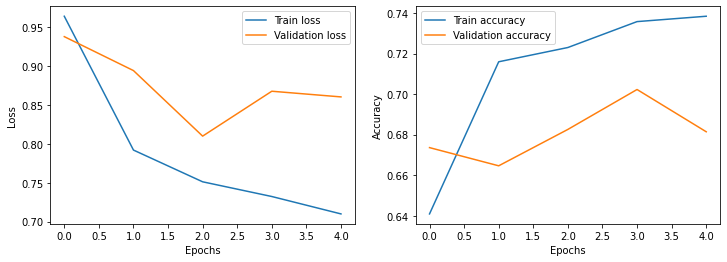

In [119]:
checkpoint1 = torch.load('/content/drive/MyDrive/Colab Notebooks/IA_Pacheco/SIS421/Practicos/Red-convolcional/ResNet18(CheckPoints)/entrenamiento_1.tar')

graficarValores(checkpoint1['train_loss_list'], checkpoint1['val_loss_list'], checkpoint1['train_acc_list'], checkpoint1['val_acc_list'])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


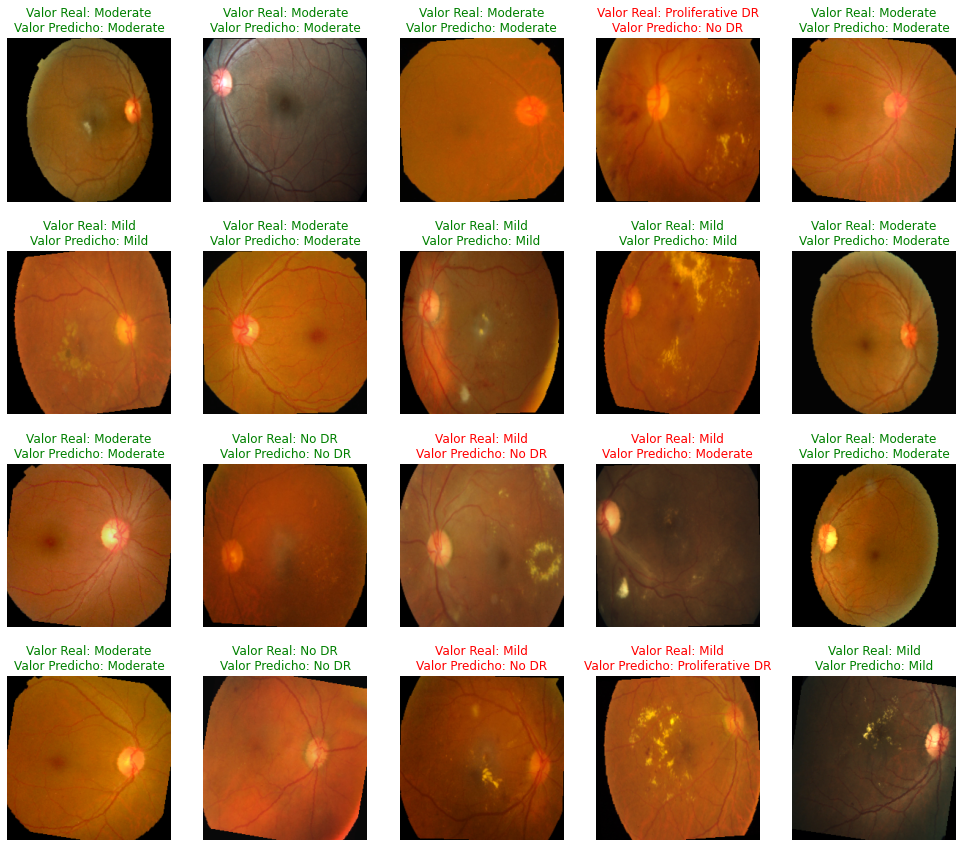

In [122]:
model = Diabetic()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/IA_Pacheco/SIS421/Practicos/Red-convolcional/ResNet18(CheckPoints)/entrenamiento_1.tar')['model_state_dict'])
model.eval()

graficar(model)

#Transfer Learning

In [123]:
# lr = 0.001
# epochs=5
model_c = Diabetic(pretrained=True, freeze=True)
fit(model_c, dataloader, lr=0.001, PATH='/content/drive/MyDrive/Colab Notebooks/IA_Pacheco/SIS421/Practicos/Red-convolcional/ResNet18(CheckPoints)/entrenamiento_2(Transfer Learning).tar')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No existe checkpoint


val_loss 1.06477 val_acc 0.65365: 100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


Epoch 1/5 loss 1.19990 val_loss 1.06477 acc 0.55541 val_acc 0.65365


val_loss 0.89150 val_acc 0.67361: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


Epoch 2/5 loss 0.92100 val_loss 0.89150 acc 0.67918 val_acc 0.67361


val_loss 0.87511 val_acc 0.68576: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]


Epoch 3/5 loss 0.82145 val_loss 0.87511 acc 0.70980 val_acc 0.68576


val_loss 0.80016 val_acc 0.68953: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]


Epoch 4/5 loss 0.76619 val_loss 0.80016 acc 0.71842 val_acc 0.68953


val_loss 0.77427 val_acc 0.70312: 100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


Epoch 5/5 loss 0.73272 val_loss 0.77427 acc 0.73885 val_acc 0.70312


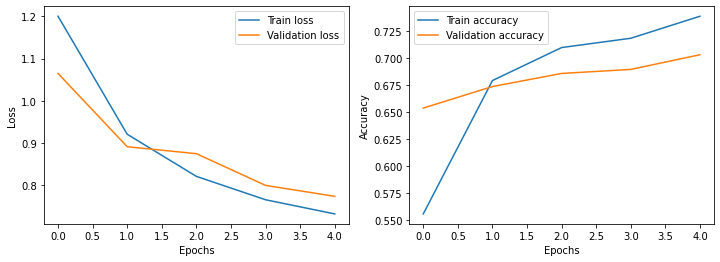

In [124]:
checkpoint2 = torch.load('/content/drive/MyDrive/Colab Notebooks/IA_Pacheco/SIS421/Practicos/Red-convolcional/ResNet18(CheckPoints)/entrenamiento_2(Transfer Learning).tar')

graficarValores(checkpoint2['train_loss_list'], checkpoint2['val_loss_list'], checkpoint2['train_acc_list'], checkpoint2['val_acc_list'])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


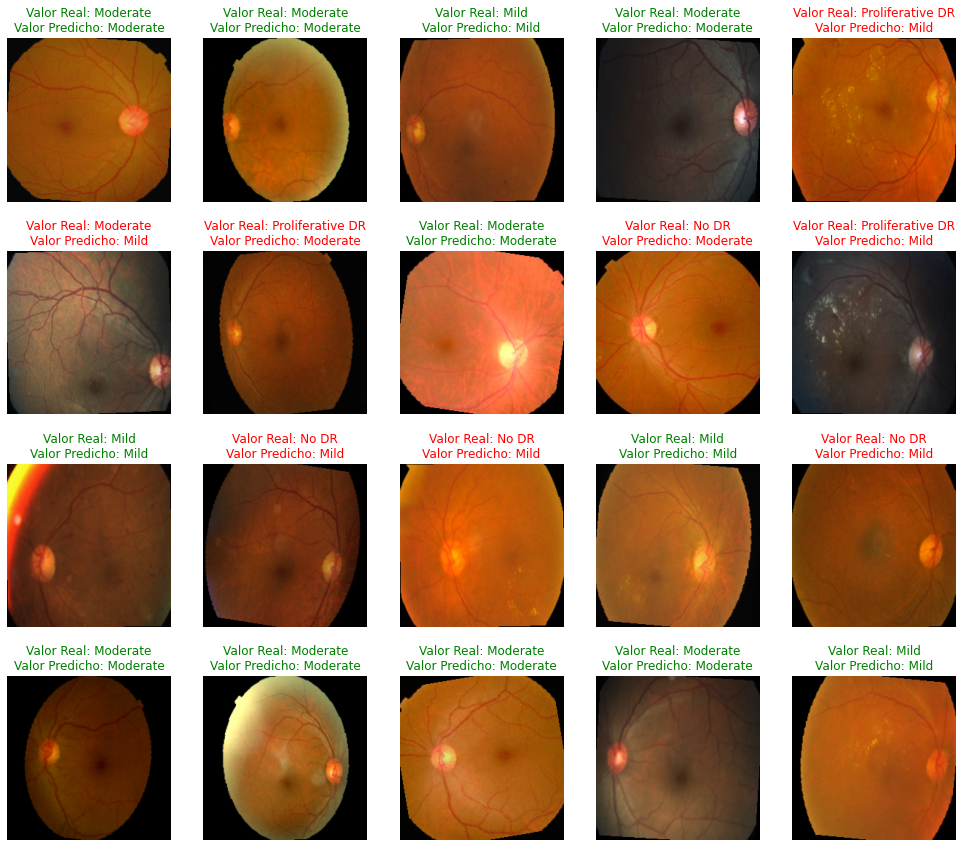

In [125]:
# Cargar el modelo que has entrenado y ponerlo en modo evaluación
model = Diabetic()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/IA_Pacheco/SIS421/Practicos/Red-convolcional/ResNet18(CheckPoints)/entrenamiento_2(Transfer Learning).tar')['model_state_dict'])
model.eval()

graficar(model)

In [84]:
# lr = 0.001
# epochs=10
model_c = Diabetic(pretrained=True, freeze=True)
fit(model_c, dataloader, epochs=10, lr=0.001, PATH='entrenamiento_3(Transfer Learning).tar')

No existe checkpoint


val_loss 1.00445 val_acc 0.66840: 100%|██████████| 18/18 [00:08<00:00,  2.18it/s]


Epoch 1/10 loss 1.14657 val_loss 1.00445 acc 0.59724 val_acc 0.66840


val_loss 0.88340 val_acc 0.67274: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


Epoch 2/10 loss 0.88387 val_loss 0.88340 acc 0.70322 val_acc 0.67274


val_loss 0.85055 val_acc 0.67969: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]


Epoch 3/10 loss 0.79549 val_loss 0.85055 acc 0.71935 val_acc 0.67969


val_loss 0.80301 val_acc 0.71267: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]


Epoch 4/10 loss 0.74447 val_loss 0.80301 acc 0.73507 val_acc 0.71267


val_loss 0.78050 val_acc 0.71354: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]


Epoch 5/10 loss 0.72463 val_loss 0.78050 acc 0.74453 val_acc 0.71354


val_loss 0.77501 val_acc 0.70920: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]


Epoch 6/10 loss 0.70284 val_loss 0.77501 acc 0.74669 val_acc 0.70920


val_loss 0.76966 val_acc 0.71528: 100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


Epoch 7/10 loss 0.68383 val_loss 0.76966 acc 0.75691 val_acc 0.71528


val_loss 0.78442 val_acc 0.72164: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]


Epoch 8/10 loss 0.67762 val_loss 0.78442 acc 0.74141 val_acc 0.72164


val_loss 0.74298 val_acc 0.70862: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 9/10 loss 0.66185 val_loss 0.74298 acc 0.75847 val_acc 0.70862


val_loss 0.72212 val_acc 0.72859: 100%|██████████| 18/18 [00:08<00:00,  2.25it/s]


Epoch 10/10 loss 0.64744 val_loss 0.72212 acc 0.75859 val_acc 0.72859


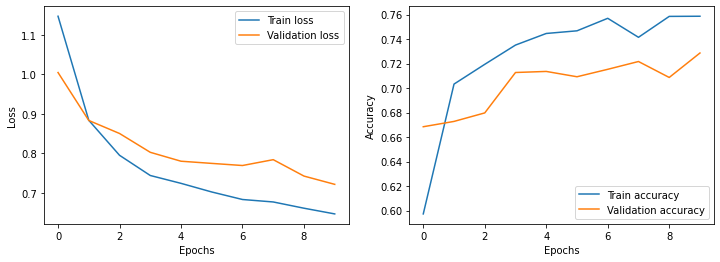

In [85]:
checkpoint3 = torch.load('entrenamiento_3(Transfer Learning).tar')

graficarValores(checkpoint3['train_loss_list'], checkpoint3['val_loss_list'], checkpoint3['train_acc_list'], checkpoint3['val_acc_list'])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


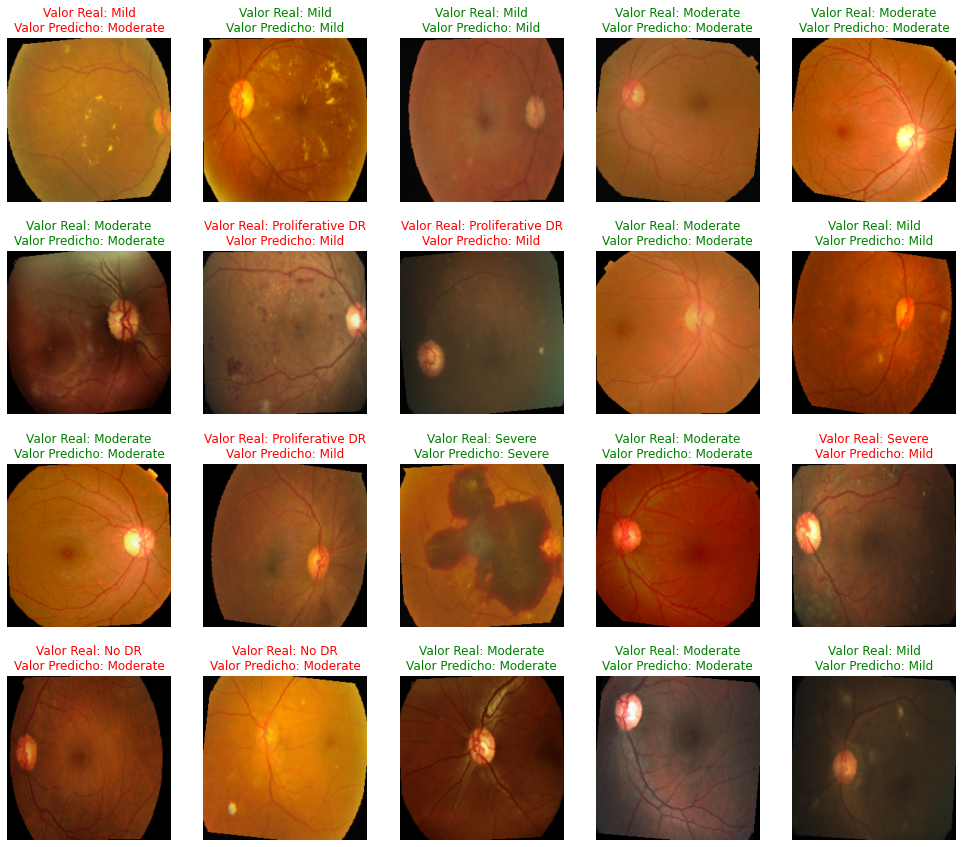

In [86]:
model = Diabetic()
model.load_state_dict(torch.load('entrenamiento_3(Transfer Learning).tar')['model_state_dict'])
model.eval()

graficar(model)

#Fine Tuning

In [103]:
# lr = 0.0001
# epochs=7
model_c = Diabetic(pretrained=True, freeze=False)
fit(model_c, dataloader, epochs=7, lr=0.0001, PATH='entrenamiento_4(Fine Tuning).tar')

No existe checkpoint


val_loss 0.63787 val_acc 0.74797: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]


Epoch 1/7 loss 0.77332 val_loss 0.63787 acc 0.71481 val_acc 0.74797


val_loss 0.58534 val_acc 0.77054: 100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


Epoch 2/7 loss 0.50625 val_loss 0.58534 acc 0.81034 val_acc 0.77054


val_loss 0.56472 val_acc 0.79311: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]


Epoch 3/7 loss 0.42953 val_loss 0.56472 acc 0.84381 val_acc 0.79311


val_loss 0.56091 val_acc 0.78791: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]


Epoch 4/7 loss 0.34841 val_loss 0.56091 acc 0.87133 val_acc 0.78791


val_loss 0.58410 val_acc 0.80498: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 5/7 loss 0.29098 val_loss 0.58410 acc 0.89114 val_acc 0.80498


val_loss 0.64284 val_acc 0.77575: 100%|██████████| 18/18 [00:08<00:00,  2.08it/s]


Epoch 6/7 loss 0.23342 val_loss 0.64284 acc 0.91704 val_acc 0.77575


val_loss 0.66019 val_acc 0.78414: 100%|██████████| 18/18 [00:07<00:00,  2.30it/s]


Epoch 7/7 loss 0.19541 val_loss 0.66019 acc 0.93362 val_acc 0.78414


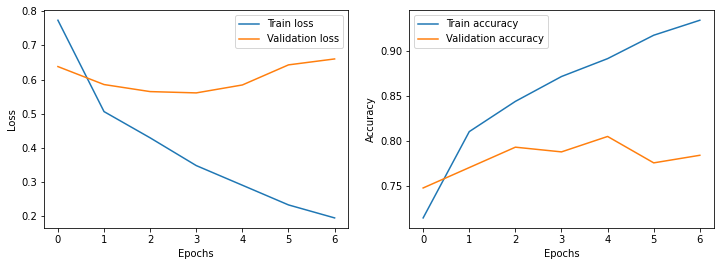

In [104]:
checkpoint4 = torch.load('entrenamiento_4(Fine Tuning).tar')

graficarValores(checkpoint4['train_loss_list'], checkpoint4['val_loss_list'], checkpoint4['train_acc_list'], checkpoint4['val_acc_list'])

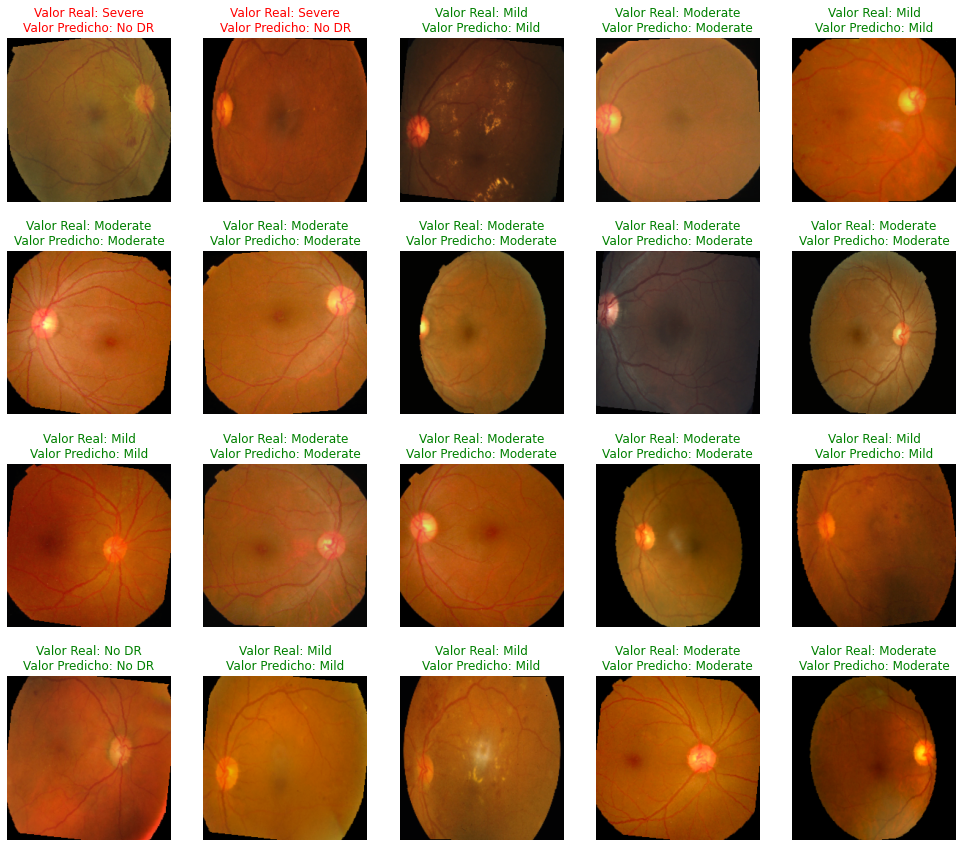

In [105]:
# Cargar el modelo que has entrenado y ponerlo en modo evaluación
model = Diabetic()
model.load_state_dict(torch.load('entrenamiento_4(Fine Tuning).tar')['model_state_dict'])
model.eval()

graficar(model)